# Projeto

In [21]:
#Importando bibliotecas
import pandas as pd
import numpy as np
import seaborn as sns
import warnings
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import plotly.express as px
import pgeocode
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import NearestNeighbors
warnings.filterwarnings("ignore")

# Limpeza e Tratamento de Dados

In [22]:
#Carregando os dados
transactional = pd.read_csv('transacoes.csv', sep=';')
test = pd.read_csv('testes.csv', sep=',')
geo = pd.read_csv('info_geo.csv', sep=',')
economic = pd.read_csv('economicos.csv', sep=',')
demographic = pd.read_csv('demograficos.csv', sep=',')

In [23]:
#transactional.info() 
transactional.dropna(inplace=True) #Removendo dados vazios
transactional.drop_duplicates(inplace=True) #Removendo dados duplicados
#transactional
transactional["Date of birth"] = pd.to_datetime(transactional["Date of birth"], format='mixed', dayfirst=True) #Transformando em data
transactional["Date of service"] = pd.to_datetime(transactional["Date of service"], format='mixed', yearfirst=True) #Transformando em data
#transactional['Gender'] = transactional['Gender'].astype('string') #Tranformando em string
transactional['Testing Cost'] = transactional['Testing Cost'].str.replace(',','.').astype(float) #Tranformando em float
#transactional.info()

#test.info()
test.dropna(inplace=True)
test.drop_duplicates(inplace=True)
#test

#geo.info()
geo.dropna(inplace=True)
geo.drop(['Unnamed: 0'],axis=1,inplace=True)
geo.drop_duplicates(inplace=True)
geo['Zipcode'] = geo['Zipcode'].astype(int)
#geo

#Separando latitude e longitude da coluna location
latitude = []
longitude = []
for i in geo['Location']:
    ll = i.split(",")
    latitude.append(ll[0])
    longitude.append(ll[1])
geo['LAT']=latitude
geo['LON']= longitude
geo['LAT'] = geo['LAT'].astype(float)
geo['LON'] = geo['LON'].astype(float)

#economic.info()
economic.dropna(inplace=True)
economic.drop(['Unnamed: 0'],axis=1,inplace=True)
economic.drop_duplicates(inplace=True)
#economic

#demographic.info()
demographic.dropna(inplace=True)
demographic.drop(['Unnamed: 0'],axis=1,inplace=True)
demographic.drop_duplicates(inplace=True)
#demographic

#Percebi que os numeros finais da coluna ID era o zipcode então resolvi separar para mesclar tabelas que tinha zipcode em comum
Zipcode = []
Zipcode1 = []

for i in economic['id']:
    zip = i[9:]
    Zipcode.append(zip)
for i in demographic['Id']:
    zip = i[9:]
    Zipcode1.append(zip)
    
    
economic.dropna(inplace=True)
economic['Zipcode'] = Zipcode
#economic
demographic['Zipcode'] = Zipcode1
demographic.dropna(inplace=True)
#demographic

demographic['Zipcode'] = demographic['Zipcode'].astype(int)
economic['Zipcode'] = economic['Zipcode'].astype(int)

#Mesclando tabelas com dados em comum para facilitar
filtrado_test =test[['CodItem', 'Desc Item', 'Testing Cost']]
filtrado_geo = geo[['Lab Id', 'Location', 'Zipcode']]
mesclado_transactional = transactional.merge(filtrado_test, on='CodItem').merge(filtrado_geo, on='Lab Id')
#mesclado_transactional
mesclado_eco_demo = economic.merge(demographic, on='Zipcode')
mesclado_eco_demo.drop(['id','Geographic Area Name','Id','GeographicAreaName'], axis=1, inplace=True)                
#mesclado_eco_demo

# Análise Exploratória de Dados

In [24]:
# Função para exibir estatísticas descritivas
def show_statistics(df):
    # Verifica e exibe estatísticas descritivas para colunas numéricas
    numeric_columns = df.select_dtypes(include=[float, int]).columns
    if len(numeric_columns) > 0:
        print("\nEstatísticas Descritivas para Colunas Numéricas:\n")
        print(df[numeric_columns].describe())
    
    # Verifica e exibe estatísticas descritivas para colunas categóricas
    categorical_columns = df.select_dtypes(include=[object]).columns
    if len(categorical_columns) > 0:
        print("\nEstatísticas Descritivas para Colunas Categóricas:\n")
        print(df[categorical_columns].describe())

print("Estatísticas para dados transacionais, testes, e geográficos:")
show_statistics(mesclado_transactional)

print("\nEstatísticas para dados economicos e demográficos:")
show_statistics(mesclado_eco_demo)

Estatísticas para dados transacionais, testes, e geográficos:

Estatísticas Descritivas para Colunas Numéricas:

            CodItem  Testing Cost_x  Testing Cost_y       Zipcode
count  2.338871e+06    2.338871e+06    2.338871e+06  2.338871e+06
mean   7.000322e+07    5.112028e+01    1.560471e+01  5.278856e+04
std    1.907615e+03    9.787902e+01    4.187324e+01  3.768114e+04
min    7.000004e+07    0.000000e+00    0.000000e+00  1.605000e+03
25%    7.000113e+07    1.100000e+01    1.230000e+00  1.914000e+04
50%    7.000376e+07    2.400000e+01    2.390000e+00  3.028100e+04
75%    7.000446e+07    4.900000e+01    4.970000e+00  9.458800e+04
max    7.000900e+07    9.500000e+03    1.762460e+03  9.838300e+04

Estatísticas Descritivas para Colunas Categóricas:

       Patient Id   Gender      Service Id   Lab Id  \
count     2338871  2338871         2338871  2338871   
unique     501025        3          659529      116   
top     9999999-1        F  6004395771-8-1     L133   
freq         1411  1

#### Observando as colunas percebi que poderia criar outras features com os dados de 'Date of birth' e 'Date of service' podemos saber a idade e com 'Testing Cost_x': quanto o teste custa para o cliente e 'Testing Cost_y': quanto o teste custa para o laboratório, podemos saber o lucro.

In [25]:
#Criando features de lucro e de idade
mesclado_transactional['idade'] = np.ceil((mesclado_transactional['Date of service'] - mesclado_transactional['Date of birth']) / pd.Timedelta(days=365.25))
mesclado_transactional['lucro'] = mesclado_transactional['Testing Cost_x'] - mesclado_transactional['Testing Cost_y']
#Criando dataframe com dados dos pacientes
pacientes=mesclado_transactional.groupby(['Patient Id', 'Gender', 'idade'])['Testing Cost_x'].sum().reset_index()

In [26]:
#Retirando outliers pois foram percebidas inconsistências nas idades
from scipy import stats
#Calculando z-score 
z = np.abs(stats.zscore(pacientes['idade']))

#Identificando outliers
threshold = 3
outliers = pacientes['idade'][z > threshold]

pacientes = pacientes.drop(outliers.index)

#### De acordo com a base de dados formulei as seguintes perguntas:

    - Qual o publico alvo e quanto eles gastam?
    - Quais lugares lucram mais e suas caracteristicas?
    
#### e a seguinte estratégia:

    - Procurar por locais que atendem o publico alvo e que tenham caracteristicas semelhantes aos que mais lucraram.

In [27]:
gastos_por_genero= pacientes.groupby(['Gender'])['Testing Cost_x'].sum().reset_index()
gastos_idade_e_genero=pacientes.groupby(['Gender','idade'])['Testing Cost_x'].sum().reset_index()

In [28]:
#Lucro por laboratório existente
lucro=mesclado_transactional.groupby(['Zipcode'])['lucro'].sum().reset_index()
onde_tem_lab = mesclado_eco_demo.merge(lucro, on='Zipcode')

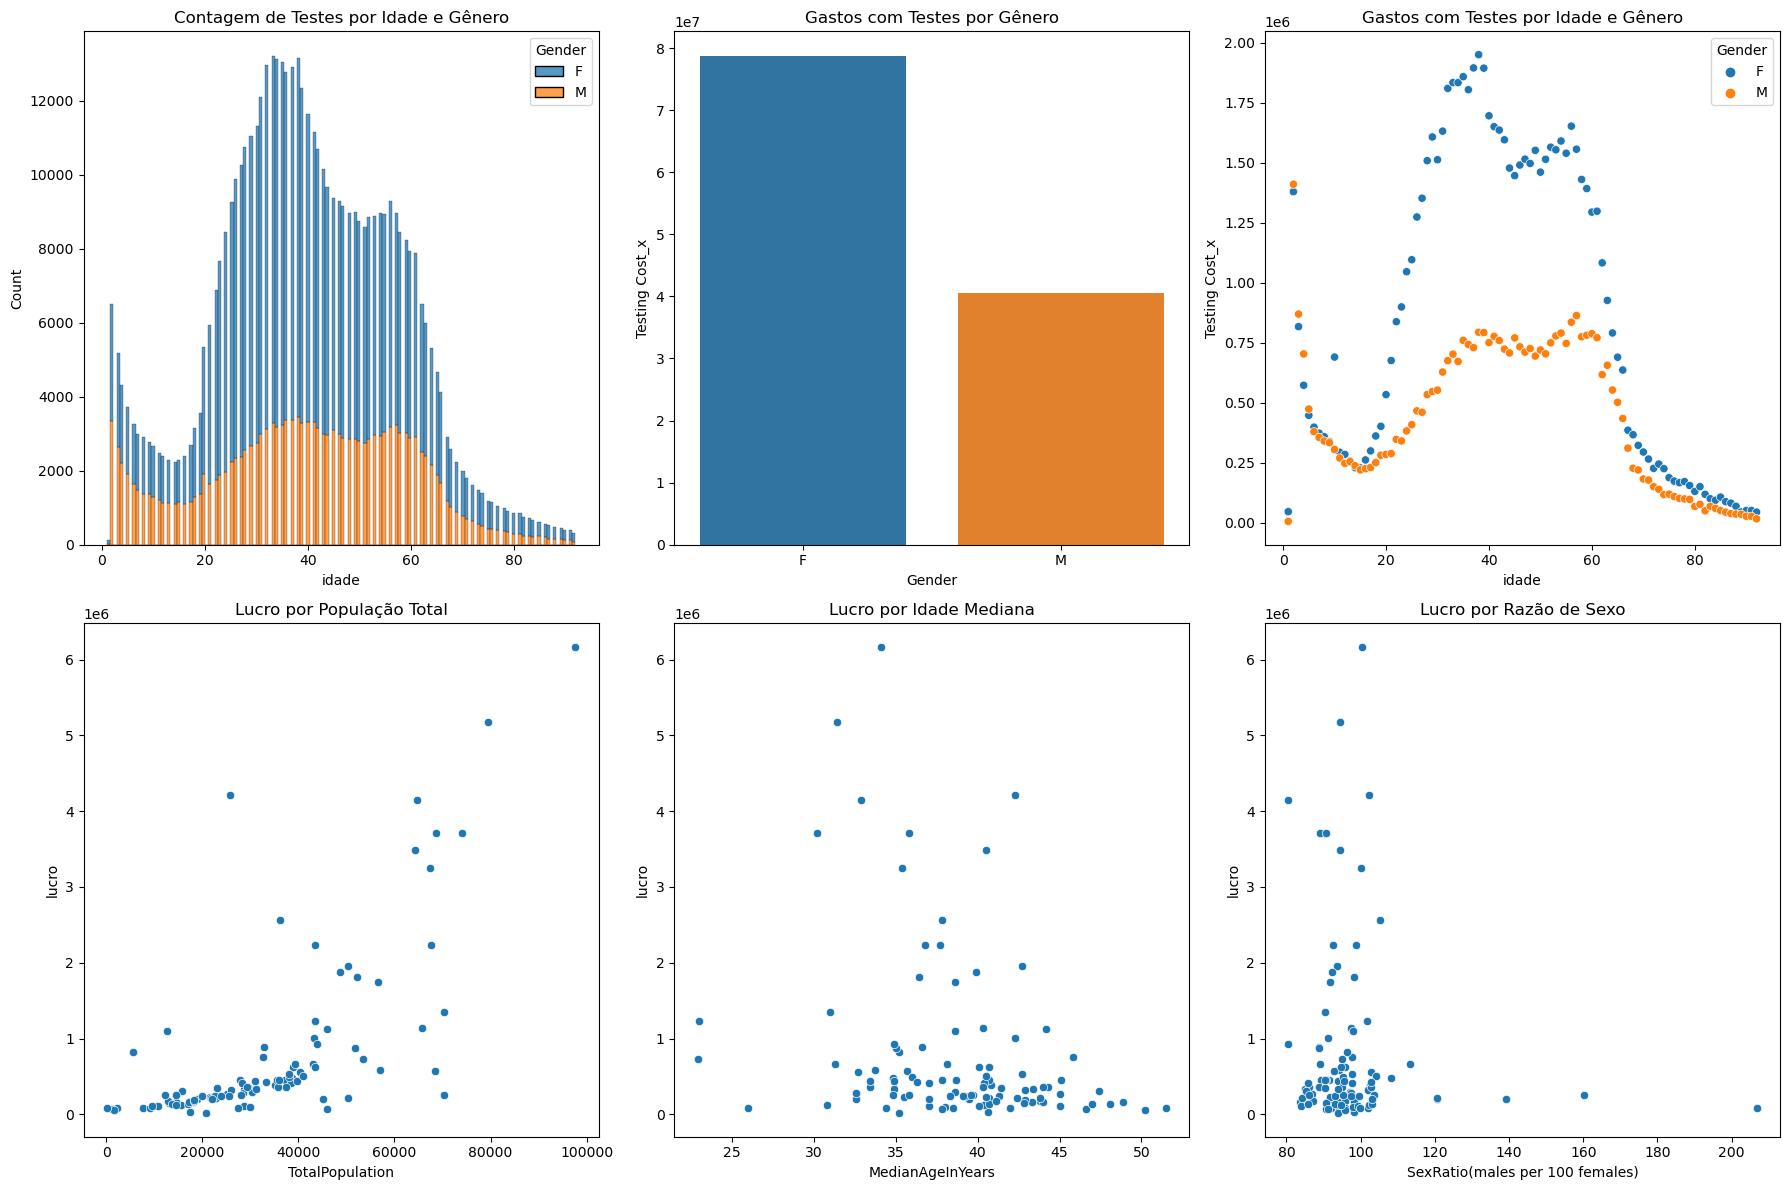

In [29]:
# Criando o subplot
fig, axes = plt.subplots(2, 3, figsize=(18, 12))

# Primeiro gráfico
sns.histplot(data=pacientes, x='idade', hue='Gender', multiple="stack", ax=axes[0, 0])
axes[0, 0].set_title('Contagem de Testes por Idade e Gênero')

# Segundo gráfico
sns.barplot(data=gastos_por_genero, x='Gender', y='Testing Cost_x', ax=axes[0, 1])
axes[0, 1].set_title('Gastos com Testes por Gênero')

# Terceiro gráfico
sns.scatterplot(data=gastos_idade_e_genero, x='idade', y='Testing Cost_x', hue='Gender', ax=axes[0, 2])
axes[0, 2].set_title('Gastos com Testes por Idade e Gênero')

# Quarto gráfico
sns.scatterplot(x="TotalPopulation", y="lucro", data=onde_tem_lab, ax=axes[1, 0])
axes[1, 0].set_title('Lucro por População Total')

# Quinto gráfico
sns.scatterplot(data=onde_tem_lab, x='MedianAgeInYears', y='lucro', ax=axes[1, 1])
axes[1, 1].set_title('Lucro por Idade Mediana')

# Sexto gráfico
sns.scatterplot(data=onde_tem_lab, x='SexRatio(males per 100 females)', y='lucro', ax=axes[1, 2])
axes[1, 2].set_title('Lucro por Razão de Sexo')

# Ajustando o layout
plt.tight_layout()

# Mostrando o plot
plt.show()

#### Analisando os gráficos percebe-se que mulheres gastam mais com exames que homens, entre 20 e 60 anos a diferença aumenta muito, lugares mais populosos lucram mais, lucro em lugares onde a idade mediana entre 28 e 40 anos é maior e lugares onde tem mais mulheres que homens lucram mais.

#### Hipóteses: lugares que tem mais mulheres e com idade mediana entre 28 e 40 anos lucram mais?

In [30]:
#Separando cidades onde tem laboratórios que mulheres são maioria e idade mediana entre 28 e 40
maioria_mulher=onde_tem_lab.loc[ 
    (onde_tem_lab['SexRatio(males per 100 females)'] < 100) & 
    (onde_tem_lab['MedianAgeInYears'] > 28) &
    (onde_tem_lab['MedianAgeInYears'] < 40)]
df_aux= onde_tem_lab.drop(maioria_mulher.index)

#### Comparação entre a média de lucro em lugares que a maioria são mulheres e lugares que elas não são maioria.

In [31]:
maioria_mulher['lucro'].mean()

986872.6187804877

In [32]:
df_aux['lucro'].mean()

671269.177704918

#### Resultado: lugares onde tem laboratórios que mulheres são maioria e idade mediana entre 28 e 40, em média, lucram mais.

# Machine Learning

#### Seguindo essa premissa vamos buscar lugares que não tem laboratórios, mulheres são maioria e idade mediana entre 28 e 40, pois em média esses lugares lucram mais.

In [33]:
#Ordenando lugares com laboratório por lucro e separando os 4 primeiros para treinar o algoritmo
com_lab = maioria_mulher.sort_values(by='lucro', ascending=False).head(4)
#Descartando algumas colunas irrelevantes
com_lab = com_lab.drop(['lucro', 'Zipcode'], axis=1)

In [34]:
#Identificar os Zipcodes dos lugares com laboratórios
zipcodes_com_labs = onde_tem_lab['Zipcode'].unique()

#Filtrar o dataframe para pegar o dados dos lugares que não tem laboratórios
n_tem_lab = mesclado_eco_demo[~mesclado_eco_demo['Zipcode'].isin(zipcodes_com_labs)]

In [35]:
#Normalizando os dados
scaler = StandardScaler()
df_com_lab_scaled = scaler.fit_transform(com_lab)
df_sem_lab_scaled = scaler.transform(n_tem_lab.drop('Zipcode', axis=1))

In [36]:
#Aplicando o algoritmo KNN
knn = NearestNeighbors(n_neighbors=4, metric='manhattan')  # Ajustando n_neighbors e métrica conforme necessário
knn.fit(df_com_lab_scaled)

NearestNeighbors(metric='manhattan', n_neighbors=4)

In [37]:
#Encontrando os vizinhos mais próximos para cada lugar sem laboratório
distances, indices = knn.kneighbors(df_sem_lab_scaled)

In [38]:
#Adicionando a média das distâncias dos vizinhos mais próximos ao dataframe sem laboratórios
n_tem_lab['MeanDistanceToLab'] = distances.mean(axis=1)

#Ordenando os lugares sem laboratórios pela média das distâncias
n_tem_lab_ordenado = n_tem_lab.sort_values(by='MeanDistanceToLab')

#### Buscando zipcode para plotar gráfico de lugares para abrir laboratórios.

In [39]:
#Separando as 20 melhores cidades
melhores= n_tem_lab_ordenado.head(20)
#Transformando em lista
postal_codes = melhores['Zipcode'].values.astype('str').tolist()

#Códigos postais por iso
nomi = pgeocode.Nominatim('us')

#Buscando códigos postais
us_post = nomi.query_postal_code(postal_codes)

#Removendo colunas que não preciso
us_post.drop(['community_name','community_code'], axis=1, inplace=True)
us_post.dropna(inplace=True)

#Transformando em valor inteiro para mesclar o que as tabelas tem em comum
us_post['postal_code'] = us_post['postal_code'].astype(int)
loc = pd.merge(melhores, us_post[['postal_code', 'latitude', 'longitude', 'place_name']], how='right', left_on=['Zipcode'], right_on=['postal_code'])

fig = go.Figure(data=go.Scattergeo(
        locationmode = 'USA-states',
        lon = loc['longitude'],
        lat = loc['latitude'],
        text = loc['place_name'],
        mode = 'markers',
        marker = dict(
            size = 10,
            opacity = 0.8,
            reversescale = True,
            autocolorscale = False,
            symbol = 'square',
            line = dict(
                width=1,
                color='rgba(102, 102, 102)'
            ),
            color = loc['MeanDistanceToLab'],
            colorbar_title="Média de proximidade<br>(Quando menor, melhor)"
        )
            ))
fig.update_layout(
        title = 'Localização dos melhores lugares para abrir laboratórios',
        geo = dict(
            scope='usa',
            projection_type='albers usa',
            showland = True,
            landcolor = "rgb(250, 250, 250)",
            subunitcolor = "rgb(217, 217, 217)",
            countrycolor = "rgb(217, 217, 217)",
            countrywidth = 0.5,
            subunitwidth = 0.5
        ),
    )
fig.show()

In [40]:
top3 = loc.head(3)
top3['postal_code'] = top3['postal_code'].astype(str)
fig = px.bar(
    top3, 
    x="MeanDistanceToLab", 
    y="postal_code",
    labels={
        "postal_code": "",
        "MeanDistanceToLab": "Média de proximidade com lugares que seguem as premissas e lucraram mais",
    },
    title='Ranking: Melhores lugares'
)
fig.update_layout(
    paper_bgcolor='white',
    plot_bgcolor='white',
    title={
        'y':0.9,
        'x':0.5,
        'xanchor': 'center',    
        'yanchor': 'top'}, 
        font=dict(family="Arial",size=16),
        )
fig.update_yaxes(categoryorder='total descending')
fig.show()


### A análise demonstrou que os ZIP codes 92105, 85204 e 32210 são os mais promissores para a expansão da rede de laboratórios, considerando a demanda e as características demográficas e econômicas da população.